# Урок 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)
# Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных  
  
**_Для задания нужно вместо article.csv использовать materials.csv - там есть нужная информация._**

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

In [162]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn import metrics

Наши новости

In [4]:
news = pd.read_csv("16_2_files/materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [5]:
users = pd.read_csv("16_2_files/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

## 1. Получаем векторные представления новостей

In [6]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [7]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\demin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [10]:
with open('16_2_files/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [11]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [12]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\demin\AppData\Local\Temp\ipykernel_4512\2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: total: 24.1 s
Wall time: 24.2 s


In [13]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: total: 3min 18s
Wall time: 3min 19s


А теперь в 3 строчки обучим нашу модель

In [14]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [15]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [16]:
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [17]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [18]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.06883886),
 (1, 0.05789296),
 (2, 0.3747683),
 (3, 0.058712825),
 (4, 0.078067854),
 (15, 0.12826766),
 (16, 0.045942236),
 (23, 0.1333224),
 (24, 0.03987048)]

In [19]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: производитель кость одежда виза обнаружить выдать билет
topic_1: год россия рост это продукция фестиваль форум
topic_2: мочь это всё год который исследование технология
topic_3: это который год компания новый система работа
topic_4: рак золото россиянин калифорния пограничный бензин показ
topic_5: напомнить соглашение договор сенатор сообщество грант терминал
topic_6: двигатель вода обращение расстояние тип пространство скорость
topic_7: путин северный nn пресссекретарить песок корея владимир
topic_8: земля который город nn время район год
topic_9: фонд превысить применение препарат след регистрация направлять
topic_10: газ снижение экипаж километр ввс источник таиланд
topic_11: год млрд млн рубль банк который тыс
topic_12: мозг смерть обнаружить писать который год это
topic_13: это год который россия сша также российский
topic_14: ребёнок свой жизнь это женщина человек который
topic_15: египет характерный вдвое коллекция альянс лестница занятость
topic_16: который год это дел

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [20]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [220]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.014350,0.113280,0.000000,0.000000,0.020612,0.0,0.000000,0.0,0.0,...,0.000000,0.256791,0.587647,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,4896,0.000000,0.000000,0.000000,0.000000,0.142597,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.284576,0.0,0.000000,0.0,0.000000,0.0,0.348896,0.000000
2,4897,0.068337,0.057753,0.371889,0.058711,0.076906,0.0,0.000000,0.0,0.0,...,0.128330,0.045697,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.133159,0.044903
3,4898,0.000000,0.000000,0.392852,0.000000,0.000000,0.0,0.207207,0.0,0.0,...,0.075428,0.063258,0.000000,0.0,0.016481,0.0,0.000000,0.0,0.000000,0.181302
4,4899,0.063954,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.683539,0.000000,0.0,0.000000,0.0,0.228041,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

## 2. Следующий шаг - векторные представления пользователей

In [221]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [222]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [223]:
doc_dict[293622]

array([0.        , 0.04417343, 0.1156554 , 0.        , 0.        ,
       0.        , 0.        , 0.08255798, 0.09607103, 0.        ,
       0.        , 0.03759267, 0.12856141, 0.213618  , 0.24325657,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02879427, 0.        , 0.        ])

### Применим TF-IDF меру к id статей 

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [95]:
users['articles'].iloc[0]

'[293672, 293328, 293001, 293622, 293126, 1852]'

In [96]:
tfidf = TfidfVectorizer(max_features=len(news))
tfidf.fit(users['articles'])

TfidfVectorizer(max_features=27000)

In [97]:
idf_articles = pd.DataFrame({'article_id': tfidf.get_feature_names_out(),
                             'idf': tfidf.idf_})

idf_articles

,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


In [98]:
len(idf_articles)

14781

In [99]:
idf_articles.loc[idf_articles['article_id'] == '1']

,article_id,idf


In [100]:
idf_articles.to_csv("articles_idf.csv", index=None)

#### Получим эмбединги пользователей для кодировки статей в виде TF-IDF  
**_Преобразуем уже имеющиеся переменные_**

In [101]:
doc_dict_idf = dict(zip((idf_articles['article_id'].values), idf_articles['idf'].values))

In [160]:
# Усреднение np.median
def get_user_embedding_with_idf(user_articles_list):
    # user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[int(doc_id)] for doc_id in user_articles_list])
    user_vector_idf = np.array([doc_dict_idf.get(doc_id, 0.0) for doc_id in user_articles_list])
    user_vector_weighted = user_vector * user_vector_idf[:,None] #поэлементное умножение матрицы на вектор
    user_vector = np.median(user_vector_weighted, 0)
    return user_vector

In [161]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_with_idf(x.split()), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(num_topics)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(num_topics)]]
user_embeddings.head(3)

ValueError: invalid literal for int() with base 10: '[293672,'

<div class="burk">К сожалению не смог понять в чем ошибка
</div><i class="fa fa-lightbulb-o "></i>

In [214]:
doc_dict = dict(zip((idf_articles['article_id'].values), idf_articles['idf'].values))

In [110]:
# TF-IDF
def get_user_embedding(user_articles_list):
    # user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict.get(doc_id, 0.0) for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [111]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x.split()), 1)])
user_embeddings.columns = ['mean_idf']
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['mean_idf']]
user_embeddings.head(3)

,uid,mean_idf
0,u105138,0.0
1,u108690,0.0
2,u108339,0.0


### Применим разные варианты создания эмбедингов

In [224]:
user_articles_list = users['articles'].iloc[33]

In [225]:
# np.mean
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [169]:
# np.median
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [193]:
# np.max
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [226]:
get_user_embedding(user_articles_list)

array([0.        , 0.01540616, 0.0892974 , 0.09420035, 0.        ,
       0.00377257, 0.00999127, 0.07029116, 0.01246958, 0.        ,
       0.00676285, 0.04039619, 0.01061496, 0.36610921, 0.02598076,
       0.        , 0.1402551 , 0.06295492, 0.01316396, 0.00599556,
       0.01317981, 0.        , 0.00179168, 0.        , 0.00805345])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [227]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [228]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера сообщать риа новость nn читать сообщение разговаривать автор сообщение знать откуда автор источник какихлибо основание подобный род репортаж знать откуда информация появиться сказать журналист итог встреча госсекретарь сша джон керри nn позиция свой изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать свой безопасность счёт безопасность продолжить министр слово лавров москва считать система нато создавать проблема наш безопасность поэтому декларация недостаточно мочь договариваться совместный система россия предлагать ещё начинать год президент путин посещать сша нужно вести речь очередной декларация гарантия который проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенци

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [229]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.008690,0.075415,0.032639,0.069692,0.006363,0.00000,0.000000,0.020664,0.146806,...,0.002258,0.017157,0.074388,0.083326,0.000000,0.030219,0.007952,0.028540,0.032202,0.003858
1,u108690,0.015387,0.008322,0.036404,0.125470,0.000000,0.00000,0.006883,0.007008,0.088761,...,0.000000,0.100482,0.016872,0.002630,0.000000,0.020296,0.031869,0.028030,0.019423,0.004456
2,u108339,0.004190,0.016718,0.007289,0.042191,0.000000,0.00702,0.007456,0.000000,0.144493,...,0.001949,0.087275,0.075419,0.050155,0.013678,0.025862,0.007390,0.015628,0.093008,0.003948


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [230]:
target = pd.read_csv("16_2_files/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [231]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.008690,0.075415,0.032639,0.069692,0.006363,0.00000,0.000000,0.020664,0.146806,...,0.017157,0.074388,0.083326,0.000000,0.030219,0.007952,0.028540,0.032202,0.003858,0
1,u108690,0.015387,0.008322,0.036404,0.125470,0.000000,0.00000,0.006883,0.007008,0.088761,...,0.100482,0.016872,0.002630,0.000000,0.020296,0.031869,0.028030,0.019423,0.004456,1
2,u108339,0.004190,0.016718,0.007289,0.042191,0.000000,0.00702,0.007456,0.000000,0.144493,...,0.087275,0.075419,0.050155,0.013678,0.025862,0.007390,0.015628,0.093008,0.003948,1


In [232]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [233]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [234]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1480106 , 0.10083403, 0.30876779, 0.14797765, 0.1492611 ,
       0.08966119, 0.15493918, 0.05490786, 0.05943548, 0.11329965])

## 3. Рассчитаем Precision, Recall, F_score

In [235]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.228639, F-Score=0.614, Precision=0.593, Recall=0.637


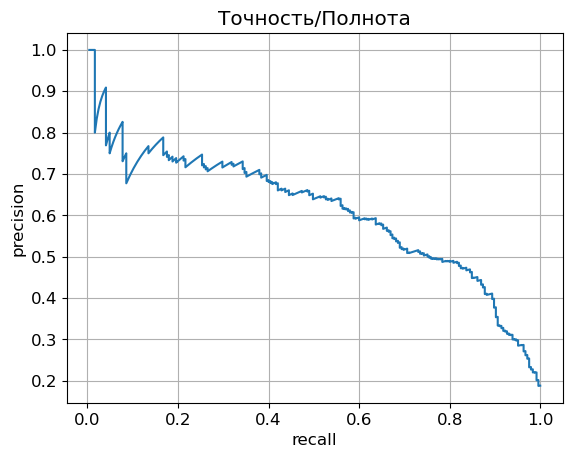

In [236]:
n = -1
plt.plot(recall[:n], precision[:n])
plt.title('Точность/Полнота')
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid('On')
plt.show()

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1648  107]
 [  90  155]]


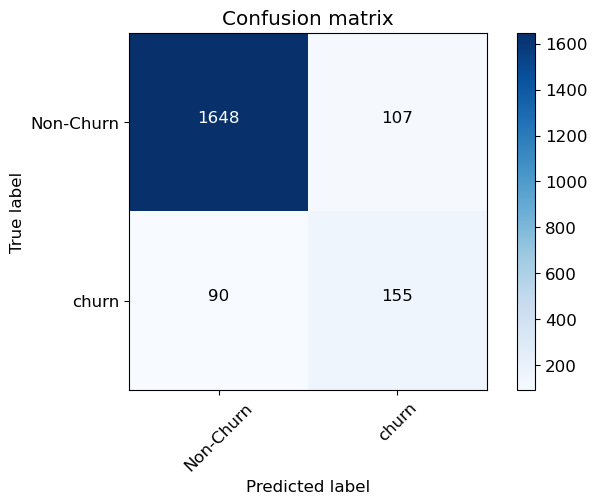

In [237]:
# np.mean

font = {'size' : 12}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(7, 5))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("16_2_files/conf_matrix_mean.png")
plt.show()

Confusion matrix, without normalization
[[1649  106]
 [  66  179]]


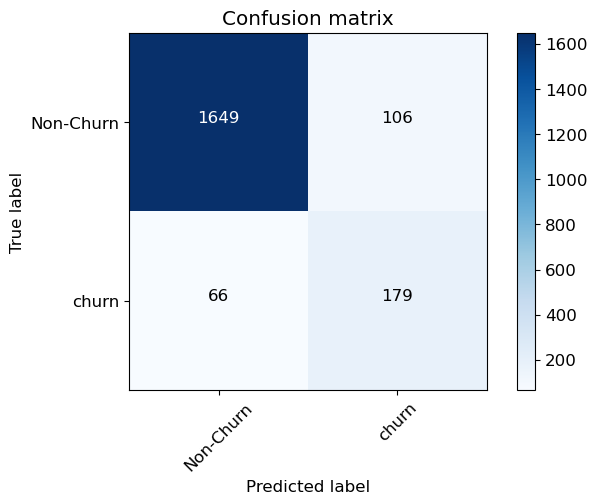

In [181]:
# np.median

font = {'size' : 12}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(7, 5))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("16_2_files/conf_matrix_median.png")
plt.show()

Confusion matrix, without normalization
[[1672   83]
 [  55  190]]


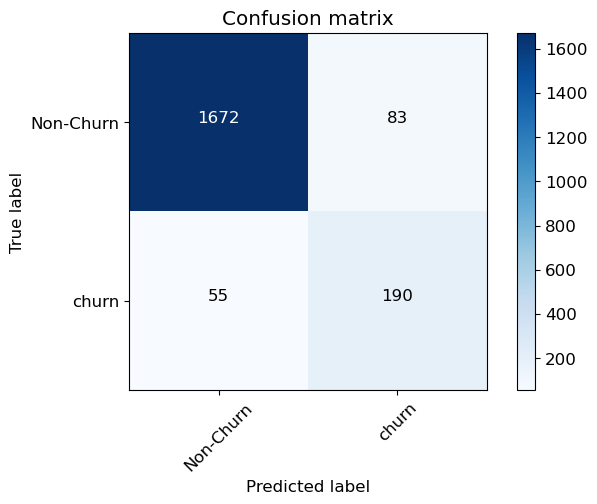

In [205]:
# np.max

font = {'size' : 12}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(7, 5))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
# plt.savefig("16_2_files/conf_matrix_max.png")
plt.show()

In [238]:
roc_auc_score = metrics.roc_auc_score(y_test, preds)

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

## 4. Занесем результат в таблицу

In [186]:
if 0:
    results_df = pd.DataFrame({'embeding':['get_user_emb_mean', 'get_user_emb_median', 'get_user_emb_max', 'idf_articles'],
                               'precision':np.nan,
                               'recall':np.nan,
                               'f_score':np.nan,
                               'roc_auc_score':np.nan})
    results_df.set_index(['embeding'], inplace=True)
if 1:
    def write_result(key1, params):
        results_df.loc[key1]['precision'] = params[0]
        results_df.loc[key1]['recall'] = params[1]
        results_df.loc[key1]['f_score'] = params[2]
        results_df.loc[key1]['roc_auc_score'] = params[3]
        return results_df

In [239]:
params  = (precision[ix], recall[ix], fscore[ix], roc_auc_score)

In [240]:
print(params)

(0.5931558935361216, 0.636734693877551, 0.6141732283464567, 0.920723297866155)


In [241]:
write_result('get_user_emb_mean', params)
# write_result('get_user_emb_median', params)
# write_result('get_user_emb_max', params)

,precision,recall,f_score,roc_auc_score
embeding,,,,
get_user_emb_mean,0.593156,0.636735,0.614173,0.920723
get_user_emb_median,0.629371,0.734694,0.677966,0.949518
get_user_emb_max,0.697080,0.779592,0.736031,0.966898
idf_articles,NaN,NaN,NaN,NaN


In [242]:
results_df.to_csv('16_2_files/results_df.csv')

In [243]:
from pandas.io.parsers.readers import read_csv
results_df = read_csv('16_2_files/results_df.csv')

In [244]:
results_df

,embeding,precision,recall,f_score,roc_auc_score
0,get_user_emb_mean,0.593156,0.636735,0.614173,0.920723
1,get_user_emb_median,0.629371,0.734694,0.677966,0.949518
2,get_user_emb_max,0.697080,0.779592,0.736031,0.966898
3,idf_articles,NaN,NaN,NaN,NaN


**_Добавим в таблицу результаты при TF-IDF-кодировании_**

In [ ]:
results_df.loc[results_df['embeding'] == 'idf_articles', 'precision'] = params[0]
results_df.loc[results_df['embeding'] == 'idf_articles', 'recall'] = params[1]
results_df.loc[results_df['embeding'] == 'idf_articles', 'f_score'] = params[2]
results_df.loc[results_df['embeding'] == 'idf_articles', 'roc_auc_score'] = params[3]

In [ ]:
results_df